In [1]:
import numpy as np
import utility
import matplotlib.pyplot as plt
import math
import logging
import data_loader

from utility import Position
from pathlib import Path
from evaluator import GoMapEvaluator
from IPython.display import display
from multiprocessing import Pool, cpu_count
from pandas import DataFrame
from GoMapClustering import AngleBalancingDBSCAN, AngleMetricDBSCAN, DBSCANFCM4DD, DBSCANx2, DBSCAN
from typing import List
from tqdm.auto import trange, tqdm
from sklearn import metrics

# Load Data

In [2]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

# data_frame = data_loader.load_aal_detections()
# truths = data_loader.load_aal_truths()

data_frame = data_loader.load_gomap_test_detections()
truths = data_loader.load_gomap_test_truths()


INFO:data_loader:Loaded 1652 detections
INFO:data_loader:1652 detections remains after applying class filter
INFO:data_loader:1652 detections remains after applying min_score >= 0.800000 filter
INFO:data_loader:1652 detections remains after applying max_distance <= 30.000000 meter filter
INFO:data_loader:Loaded 56 truths
INFO:data_loader:56 truths remains after applying class filter


In [3]:
results = DataFrame()

In [4]:
def test(data: DataFrame, cluster_algo):
    approach_name = type(cluster_algo).__name__
    print(f'Testing approach: {approach_name}')

    result = DataFrame()
    df = utility.cluster(data, cluster_algo)
    # Find the max trip count for a traffic sign
    max_trip_count = df.groupby(['cid', 'classifier']).agg(trip_count=('trip_id', 'nunique'))['trip_count'].max()

    df = df.sort_values('trip_start_time')

    for i in range(1, max_trip_count + 1):
        subset = DataFrame()
        print(f'\rAllowing {i} trip(s)', end='')

        for (cid, classifier), data in df.groupby(['cid', 'classifier']):
            trips = data['trip_id'].unique()[:i]
            # Only use data from i newest trips
            data = data[data['trip_id'].isin(trips)]
            subset = subset.append(data)

        predictions = utility.get_predictions(subset, cluster_algo, utility.compute_cluster_centroid)
        evaluation = GoMapEvaluator(predictions, truths).evaluate()

        metrics = {
            'name': approach_name,
            'max_trip_count': i,
            'min_trip_count': predictions['trip_count'].min(),
            'f1': evaluation.f1,
            'rmse_location': evaluation.rmse_location,
            'mae_location': evaluation.mae_location,
            'rmse_angle': evaluation.rmse_direction_degrees,
            'mae_angle': evaluation.mae_direction_degrees
        }
        result = result.append(metrics, ignore_index=True)

    print()
    return result

In [5]:
for approach in utility.get_approaches():
    result = test(data_frame, approach)
    results = results.append(result)

Testing approach: AngleMetricDBSCAN
Allowing 64 trip(s)
Testing approach: AngleBalancingDBSCAN
Allowing 64 trip(s)
Testing approach: DBSCANx2
Allowing 64 trip(s)
Testing approach: DBSCANFCM4DD
Allowing 64 trip(s)
Testing approach: DBSCAN
Allowing 92 trip(s)


<AxesSubplot:xlabel='Max. Trip Count', ylabel='MAE Angle'>

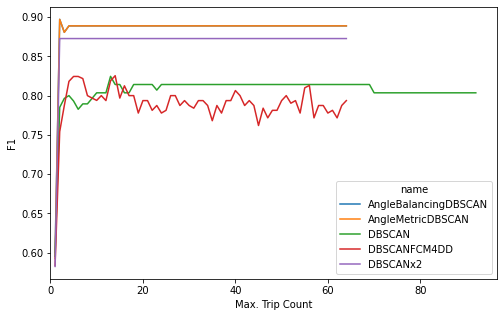

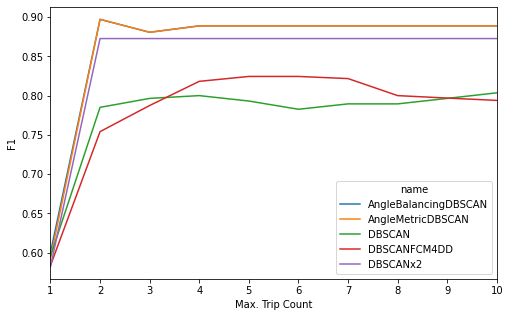

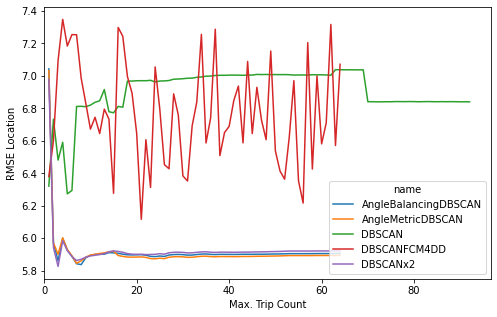

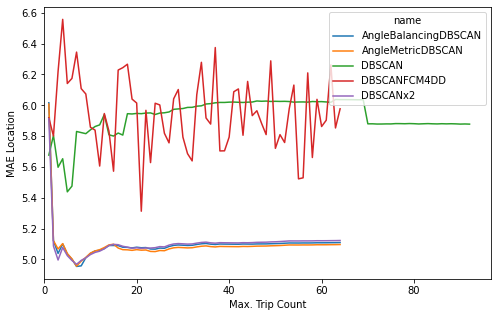

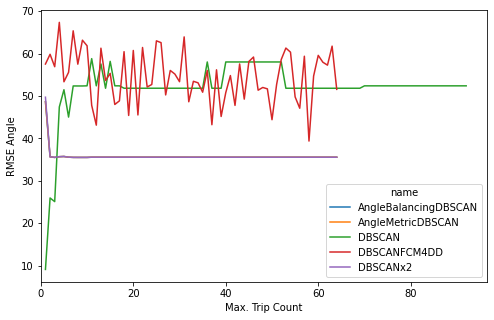

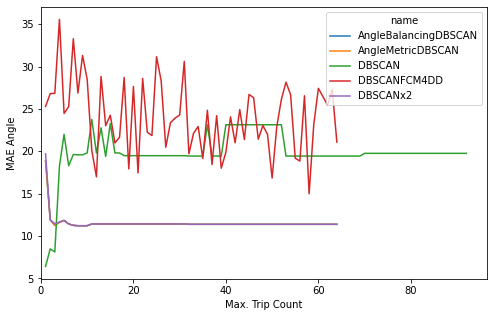

In [6]:
figsize = (8, 5)

results.pivot(index='max_trip_count', columns='name', values='f1')\
    .plot(xlabel='Max. Trip Count', xlim=(0), ylabel='F1', figsize=figsize)

results.pivot(index='max_trip_count', columns='name', values='f1')\
    .plot(xlabel='Max. Trip Count', xlim=(1, 10), xticks=range(11), ylabel='F1', figsize=figsize)

results.pivot(index='max_trip_count', columns='name', values='rmse_location')\
    .plot(xlabel='Max. Trip Count', xlim=(0), ylabel='RMSE Location', figsize=figsize)

results.pivot(index='max_trip_count', columns='name', values='mae_location')\
    .plot(xlabel='Max. Trip Count', xlim=(0), ylabel='MAE Location', figsize=figsize)

results.pivot(index='max_trip_count', columns='name', values='rmse_angle')\
    .plot(xlabel='Max. Trip Count', xlim=(0), ylabel='RMSE Angle', figsize=figsize)

results.pivot(index='max_trip_count', columns='name', values='mae_angle')\
    .plot(xlabel='Max. Trip Count', xlim=(0), ylabel='MAE Angle', figsize=figsize)


In [7]:
output = Path() / 'output'
output.mkdir(parents=True, exist_ok=True)

results.pivot(index='max_trip_count', columns='name', values='f1').to_csv(output.joinpath('f1_vs_max_trip.csv'))
results.pivot(index='max_trip_count', columns='name', values='mae_location').to_csv(output.joinpath('mae_location_vs_max_trip.csv'))
results.pivot(index='max_trip_count', columns='name', values='mae_angle').to_csv(output.joinpath('mae_angle_vs_max_trip.csv'))